<a href="https://colab.research.google.com/github/nhuang37/GNN_community_detection/blob/main/Experiment_real_world_ablation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Utils

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")
%cd /content/drive/MyDrive/JHU/Luana

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
/content/drive/MyDrive/JHU/Luana


In [ ]:
import math
import random
import os
import numpy as np
import numpy.random as npr
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse.linalg._eigen.arpack import ArpackError
from torch.nn.utils.parametrizations import orthogonal
import pickle
import seaborn as sns
import copy
from collections import defaultdict


In [ ]:
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#### Bash script to run experiments for both Cora and CiteSeer graphs

In [ ]:
!python sparsify.py --datasets planetoid

In [ ]:
!python sparsify.py --datasets planetoid --sparsify_pct 20

In [ ]:
!python sparsify.py --datasets planetoid --sparsify_pct 70

#### Plot results

In [ ]:
#source: https://gist.github.com/ihincks/6a420b599f43fcd7dbd79d56798c4e5a
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [ ]:

def show_results_sub(result_list, name='Cora'):
  fig, axs = plt.subplots(ncols=3, figsize=(12,3), sharex=True, sharey=True, dpi=100)
  names = ["original","drop(20)","drop(70)"]
  colors = {'SE(150)': lighten_color('tab:blue', 0.6), 'SE(200)': 'tab:blue', 'GNN(lin)': lighten_color('tab:orange', 0.6), 'GNN(non)': 'tab:orange'}
  styles = {'SE(150)':'-','SE(200)':'--', 'GNN(lin)':'--', 'GNN(non)':'-'}
  for i, result in enumerate(result_list):
    print(names[i])
    axs[i].set_title(names[i])
    for key, value in result[name].items():
      if i == 0:
        axs[i].plot(value, label=key, color=colors[key], alpha=0.9, linewidth=2, linestyle=styles[key])
        print(f"method={key}, acc={np.array(value).mean()*100:.2f}, std = {np.array(value).std()*100/np.sqrt(10):.2f}")

      else:
        data= np.array(value)
        axs[i].errorbar(np.arange(10), data.mean(axis=0), yerr = data.std(axis=0)/np.sqrt(10), label=key, color=colors[key], alpha=0.9, linewidth=2, linestyle=styles[key])
        print(f"method={key}, acc={data.mean()*100:.2f}, std = {data.std()*100/10:.2f}") #we have 10 random graphs, each one with 10 different splits = 100 runs => np.sqrt(100) = 10

    axs[i].legend(['SE(100)', 'SE(150)', 'GNN(lin)', 'GNN(non)'], fontsize=12)
    axs[i].set_xlabel("data split instances", fontsize=12)
    axs[i].set_ylabel("average test accuracy", fontsize=12)
  fig.suptitle(name, y=1.02)
  plt.show()

In [ ]:

norm_flag = False
dname = "planetoid"

result_d = pickle.load(open(f"result/data={dname}_pct=0_degree=2_SPonly=False_GNNonly=False_norm={norm_flag}_type=global_edges=5", "rb" ) )
result_20 = pickle.load(open(f"result/data={dname}_pct=20_degree=2_SPonly=False_GNNonly=False_norm={norm_flag}_type=global_edges=5", "rb" ) )
result_70 = pickle.load(open(f"result/data={dname}_pct=70_degree=2_SPonly=False_GNNonly=False_norm={norm_flag}_type=global_edges=5", "rb" ) )
result_list = [result_d, result_20, result_70]


original
method=SE(150), acc=77.78, std = 0.73
method=SE(200), acc=75.97, std = 0.63
method=GNN(lin), acc=85.45, std = 0.33
method=GNN(non), acc=86.24, std = 0.31
drop(20)
method=SE(150), acc=75.99, std = 0.22
method=SE(200), acc=74.64, std = 0.18
method=GNN(lin), acc=84.49, std = 0.15
method=GNN(non), acc=85.22, std = 0.11
drop(70)
method=SE(150), acc=68.88, std = 0.19
method=SE(200), acc=67.29, std = 0.20
method=GNN(lin), acc=79.92, std = 0.16
method=GNN(non), acc=80.54, std = 0.17


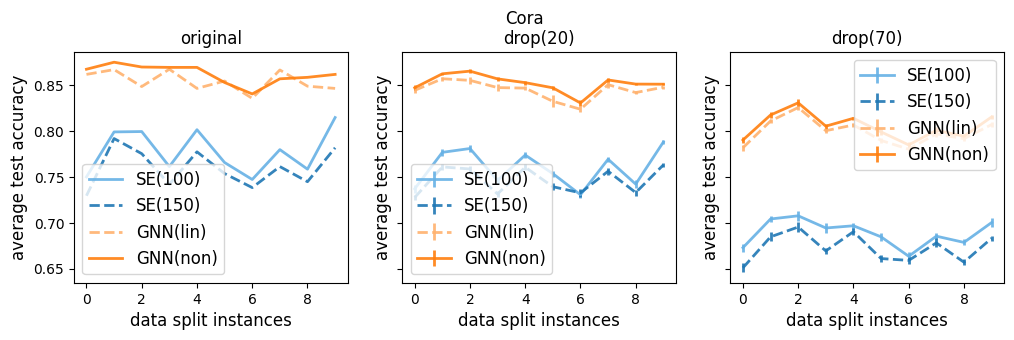

In [ ]:
show_results_sub(result_list)

original
method=SE(150), acc=63.70, std = 0.65
method=SE(200), acc=61.95, std = 0.95
method=GNN(lin), acc=75.21, std = 0.48
method=GNN(non), acc=75.88, std = 0.47
drop(20)
method=SE(150), acc=62.59, std = 0.19
method=SE(200), acc=60.93, std = 0.19
method=GNN(lin), acc=74.80, std = 0.17
method=GNN(non), acc=75.39, std = 0.16
drop(70)
method=SE(150), acc=59.34, std = 0.17
method=SE(200), acc=56.86, std = 0.18
method=GNN(lin), acc=73.72, std = 0.16
method=GNN(non), acc=74.33, std = 0.15


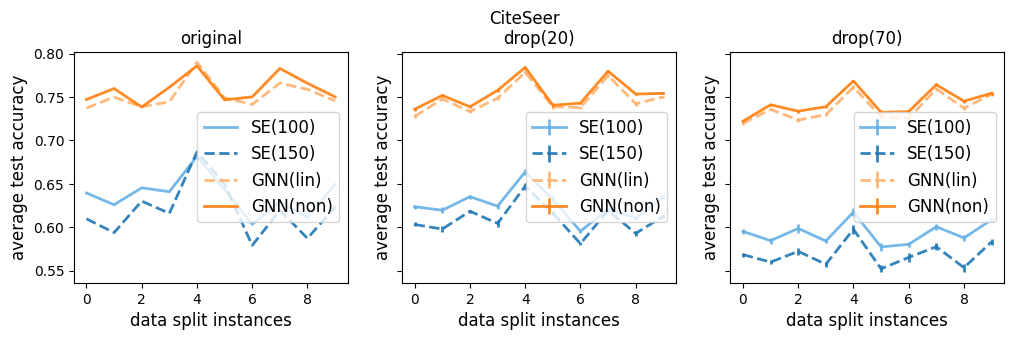

In [ ]:
show_results_sub(result_list, name="CiteSeer")